# Clean data

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import manifold, preprocessing
import warnings

In [2]:
warnings.filterwarnings('ignore')
# Grab the qualtrics output
qual_output = [i for i in os.listdir('input_data/') if i.startswith('USA_Group')][0]

# Prep responses and key--raw data
raw = pd.read_csv(os.getcwd()+'/input_data/'+qual_output)
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])

# Prep responses and key
key = pd.read_csv('input_data/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

Total number of responses from qualtrics - 172


In [3]:
# Prep relationships
filter_col = [col for col in raw if col.startswith('Q4.2')]
relationships = pd.read_csv('input_data/group_relationships_fix_label_all.csv', index_col=0)
relationships = relationships.iloc[:,0].to_list()

# Prep dimensions
dimensions = key['dimension'].tolist()[1:-1]
items_to_remove = ["foil", "foil size"]
dimensions = [item for item in dimensions if item not in items_to_remove]

dimension_frames = {}
count = 1
for dim in dimensions:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q' + str(key['block'].iloc[count]) + '.2')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])    
    count += 1
# Get total number of relationships and dimensions    
print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
print("Total number of dimensions - " + str(len(dimensions)))

Total number of relationships - 40
Total number of dimensions - 33


## time/foil/foil_size

In [4]:
time = pd.to_numeric(raw_reorg['Duration (in seconds)'], errors='coerce')
time[time > time.mean() + 3.5 * time.std()]
outliers_max = time.index[time == time.max()]
time = time[~time.index.isin(outliers_max)]
#outliers = time[time < time.mean() - 3.5 * time.std()]
outliers = time[time < 300]
outliers

1      277
26     230
31     282
35     227
61     249
76     148
82     232
86     213
97     180
120    177
130    250
131    171
137    228
158    203
Name: Duration (in seconds), dtype: int64

In [5]:
time = pd.to_numeric(raw_reorg['Duration (in seconds)'], errors='coerce')
print(time.max())
time_max_index = time.index[time == time.max()]
time = time[~time.index.isin(time_max_index)]
time = pd.DataFrame(time)

time['Q2'] =raw_reorg['Q2']
# time = time.apply(pd.to_numeric)
time_melt = pd.melt(time, id_vars='Q2')

outliers_time_list = list(time_max_index)
for col in time.columns[:-1]:
    outliers_time_list = outliers_time_list + list(time[time[col] < time[col].mean()-time[col].std()*1.5].index)
outliers_time_list = set(outliers_time_list)

outliers_time_list

3763


{150}

In [6]:
# Check foils to exclude people
foil_items = [x for x in raw.columns.tolist() if x.startswith('Q38.1')]
foil_items = raw[foil_items].iloc[0]
foil_items = [i.split(' - ', 1)[1] if ' - ' in i else i for i in foil_items]

filtered_cols = [col for col in raw_reorg if col.startswith('Q38.1')]
foils_size = pd.DataFrame(responses[filtered_cols])

#foils_size.columns = foil_items
count = 1
foil_item_new = []
for i in foil_items:
    j = i + '.' +str(count)
    
    if i == 'Rabbit':
        count = count + 1
    foil_item_new.append(j)
foils_size.columns = foil_item_new

foils_size['Q2'] =raw_reorg['Q2']
foils_size.iloc[:,0:-1] = foils_size.iloc[:,0:-1].apply(pd.to_numeric)

# Merge the identical check size questions
Q2_index_contain = foils_size[['Q2']]
Q2_index_contain['index_contain'] = Q2_index_contain.index
foils_size_melt = pd.melt(foils_size, id_vars='Q2')
foils_size_melt['variable_new'] = foils_size_melt['variable'].str.extract('([A-Za-z]+)')
foils_size = foils_size_melt.pivot_table(index='Q2',columns='variable_new',values='value')
foils_size['Q2'] = foils_size.index
foils_size = foils_size.reset_index(drop=True)
foils_size = foils_size.merge(Q2_index_contain,left_on='Q2',right_on='Q2')
foils_size.index = foils_size.index_contain
foils_size = foils_size.drop('index_contain',axis=1)
foils_size = foils_size.rename_axis(index='index')
foils_size_melt = pd.melt(foils_size, id_vars='Q2')

In [7]:
# Check for values above means for unexpected foils
outliers_size_list = []
for col in foils_size.columns[:-1]:
    outliers_size_list = outliers_size_list + list(foils_size[(foils_size[col] > foils_size[col].mean()+foils_size[col].std()*3.5) |
                   (foils_size[col] < foils_size[col].mean()-foils_size[col].std()*3.5)].index)
outliers_size_list = set(outliers_size_list)
outliers_size_list

{20, 21, 23, 24, 26, 50, 58, 68, 82, 100, 104, 131, 169}

In [8]:
# Remove outliers based on assumptions of words
# Frequency of deathbed > car
# Removing subjects based on completetion time is not the best (they do okay)
foil_size_outliers = foils_size
foil_size_outliers = foil_size_outliers[~foil_size_outliers.index.isin(outliers_size_list)]
foil_size_outliers_melt = pd.melt(foil_size_outliers, id_vars='Q2')
foil_size_outliers_melt.columns = ['Q2','variable','value']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


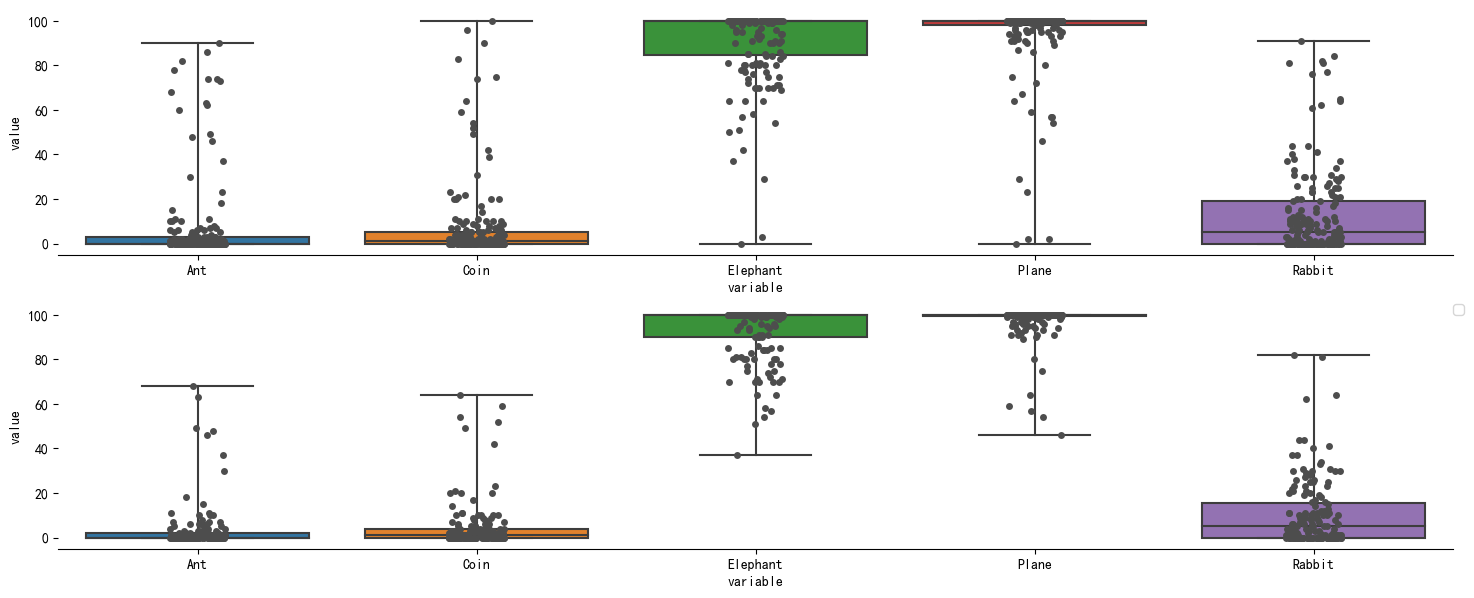

In [9]:
plt.rcParams['font.sans-serif'] = ['SimHei']
f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_size_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_size_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_size_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_size_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)

In [10]:
# Check foil_relationships to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q37')]
foil_relationships = [x[6:] for x in foil_relationships]
foil_relationships = [x for x in raw.columns.tolist() if x.startswith('Q37.1')]
foil_relationships = raw[foil_relationships].iloc[0]
foil_relationships = [s.replace('\xe2\x80\x93', '-') for s in foil_relationships]
foil_items = [i.split(' - ', 1)[1] for i in foil_relationships if ' - ' in i]

filtered_cols = [col for col in raw_reorg if col.startswith('Q37.1')]
foil_relationships = pd.DataFrame(responses[filtered_cols])
foil_relationships.columns = foil_items


count = 1
foil_relationships_new = []
for i in foil_relationships:
    j = i + '.' +str(count)
    
    if i == 'Victim - Criminal':
        count = count + 1
    foil_relationships_new.append(j)
foil_relationships.columns = foil_relationships_new

foil_relationships['Q2']  =raw_reorg['Q2']
foil_relationships.iloc[:,0:-1] = foil_relationships.iloc[:,0:-1].apply(pd.to_numeric)

# Merge the identical check size questions
Q2_index_contain = foil_relationships[['Q2']]
Q2_index_contain['index_contain'] = Q2_index_contain.index
foil_relationships_melt = pd.melt(foil_relationships, id_vars='Q2')
foil_relationships_melt['variable_new'] = foil_relationships_melt['variable'].str.extract('([A-Za-z]+)')
foil_relationships = foil_relationships_melt.pivot_table(index='Q2',columns='variable_new',values='value')
foil_relationships['Q2'] = foil_relationships.index
foil_relationships = foil_relationships.reset_index(drop=True)
foil_relationships = foil_relationships.merge(Q2_index_contain,left_on='Q2',right_on='Q2')
foil_relationships.index = foil_relationships.index_contain
foil_relationships = foil_relationships.drop('index_contain',axis=1)
foil_relationships = foil_relationships.rename_axis(index='index')
foil_relationships_melt = pd.melt(foil_relationships, id_vars='Q2')

In [11]:
# Check for values above means for unexpected foil_relationships
outliers_list = []
for rel in foil_relationships.columns[:-1]:
    outliers_list = outliers_list + list(foil_relationships[(foil_relationships[rel] > foil_relationships[rel].mean()+foil_relationships[rel].std()*3.5) |
                   (foil_relationships[rel] < foil_relationships[rel].mean()-foil_relationships[rel].std()*3.5)].index)
outliers_list = set(outliers_list)
outliers_list

{26, 97, 131, 151}

In [12]:
# Remove outliers based on assumptions of words
foil_relationships_outliers = foil_relationships
foil_relationships_outliers = foil_relationships_outliers[~foil_relationships_outliers.index.isin(outliers_list)]
foil_relationships_outliers_melt = pd.melt(foil_relationships_outliers, id_vars='Q2')
foil_relationships_outliers_melt.columns = ['Q2','variable','value']
#foil_outliers_melt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


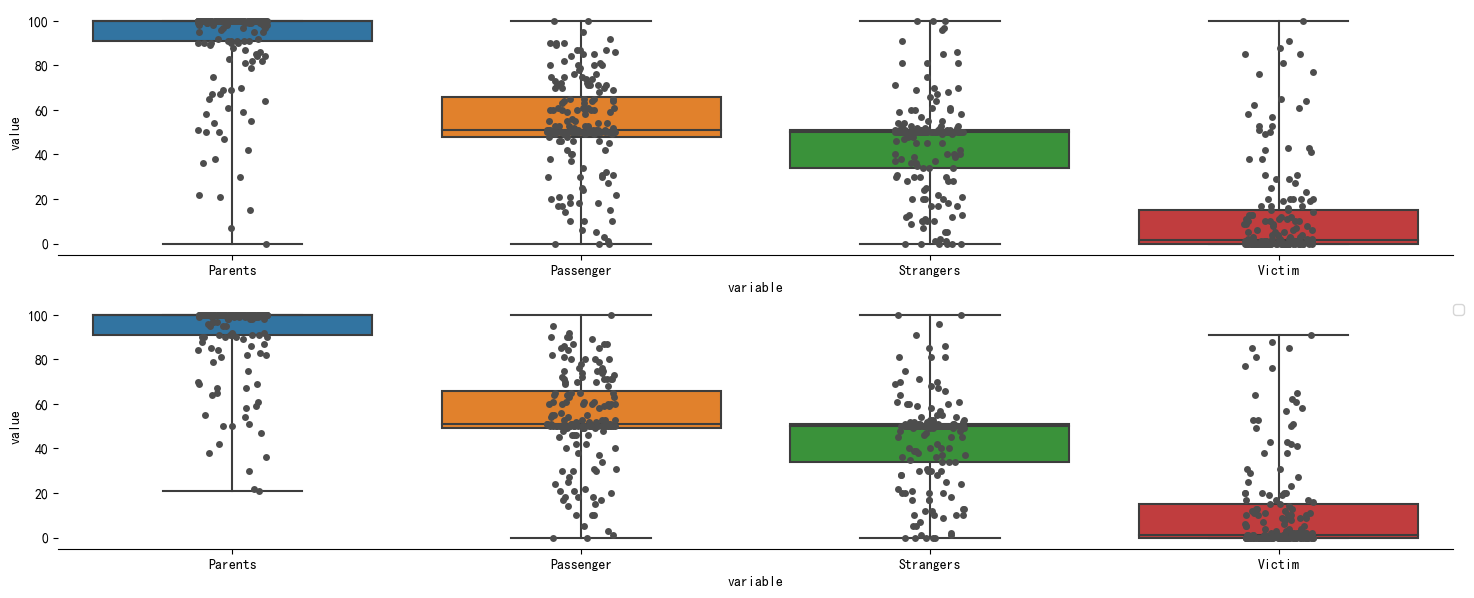

In [13]:
f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
#foil_relationships_melt['variable'] = [i.split('程度 -')[1] for i in foil_relationships_melt['variable']]
#foil_outliers_melt['variable'] = [i.split('程度 -')[1] for i in foil_outliers_melt['variable']]
sns.stripplot(x="variable", y="value", data=foil_relationships_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_relationships_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foil_relationships_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_relationships_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)

In [14]:
# Remove relationship ratings where subjects indicated that they did not 
# understand the relationships
filtered_cols = [col for col in raw_reorg if col.startswith(('Q3.1'))]
familiarity = pd.DataFrame(raw_reorg[filtered_cols])
familiarity.columns = relationships
familiarity['Q2'] = raw_reorg['Q2']
familiarity = familiarity.apply(pd.to_numeric, errors = 'coerce')
familiarity_melt = pd.melt(familiarity, id_vars='Q2')

In [15]:
# Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

In [16]:
# Remove outliers from the rest of the data
outliers_all_list = set(list(outliers_list) + list(outliers_size_list) + list(familiarity_list)+list(outliers_time_list))
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)
    
# Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimensions)
for dim in dimensions:
    temp_df = dimension_frames_outliers[dim].count()
    temp_df.index = relationships
    num_response_outliers[dim] = temp_df

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))

Total number of responses, excluding bad participants - 156
Smallest number of ratings for a relationship - 5
Largest number of ratings for a relationship - 20


In [17]:
result_dict = dimension_frames_outliers
with pd.ExcelWriter('output_data/dict_results/USA_group.xlsx')as writer:
    for dim in result_dict.keys():
        temp_df = result_dict[dim]
        temp_df.columns = relationships
        temp_df.to_excel(writer, sheet_name = dim)

## Demographics

In [18]:
filtered_demo = [col for col in raw_reorg if col.startswith('Q39')]
response_demographic = raw_reorg.loc[:,filtered_demo]
response_demographic = response_demographic[~response_demographic.index.isin(outliers_all_list)]
response_demographic.columns = ['Age','Gender','Race','Race alternative','Occupation',
                                'Highest education','Environment','First language','First language alternative']
response_demographic.head()

,Age,Gender,Race,Race alternative,Occupation,Highest education,Environment,First language,First language alternative
0,41,Female,White,NaN,Short-cycle tertiary education,Private Investigator,City,Yes,NaN
1,41,Female,White,NaN,Lower secondary education,NaN,City,Yes,NaN
2,31,Female,White,NaN,Master or equivalent,Speech Language Pathologist,City,Yes,NaN
3,29,Female,White,NaN,Bachelor or equivalent,Customer service Agent,Countryside,Yes,NaN
4,37,Male,White,NaN,Bachelor or equivalent,Financial Analyst,Countryside,Yes,NaN


### Gender

In [19]:
response_demographic['Gender'][response_demographic['Gender'].isna()] = 'No response'
response_demographic['Gender'].value_counts()

Female                  109
Male                     45
Prefer not to answer      2
Name: Gender, dtype: int64

### Age

In [20]:
response_demographic['Age'][response_demographic['Age'].isna()] = 'No response'
response_demographic['Age'].value_counts()

41    10
39     7
31     7
30     7
38     7
45     6
35     6
25     5
24     5
52     5
53     5
40     4
29     4
37     4
48     4
47     4
28     4
50     4
33     4
46     3
44     3
42     3
27     3
68     3
34     3
26     3
43     3
66     2
59     2
49     2
55     2
32     2
62     2
36     2
70     2
69     2
57     2
72     1
60     1
54     1
71     1
58     1
64     1
23     1
51     1
65     1
20     1
Name: Age, dtype: int64

### Race

In [21]:
response_demographic['Race'][response_demographic['Race'].isna()] = 'No response'
response_demographic['Race'][response_demographic['Race'].isna()] = 'No response'
response_demographic['Race'].value_counts()

White                                  126
Black                                   12
East Asian Chinese, Japanese, etc.       9
Other (write in)                         6
South Asian Indian, Pakistani, etc.      2
Arabic, Central Asian                    1
Name: Race, dtype: int64

### Highest education

In [22]:
response_demographic['Highest education'][response_demographic['Highest education'].isna()] = 'No response'
response_demographic['Highest education'][response_demographic['Highest education'].isna()] = 'No response'
response_demographic['Highest education'].value_counts()

Homemaker              6
homemaker              5
Retail                 3
Manager                3
Supervisor             2
                      ..
Data analysis          1
Bank teller            1
desk administration    1
none                   1
Associate              1
Name: Highest education, Length: 131, dtype: int64

### First language

In [23]:
response_demographic['First language'][response_demographic['First language'].isna()] = 'No response'
response_demographic['First language'][response_demographic['First language'].isna()] = 'No response'
response_demographic['First language'].value_counts()

Yes    152
No       4
Name: First language, dtype: int64

## Heatmap

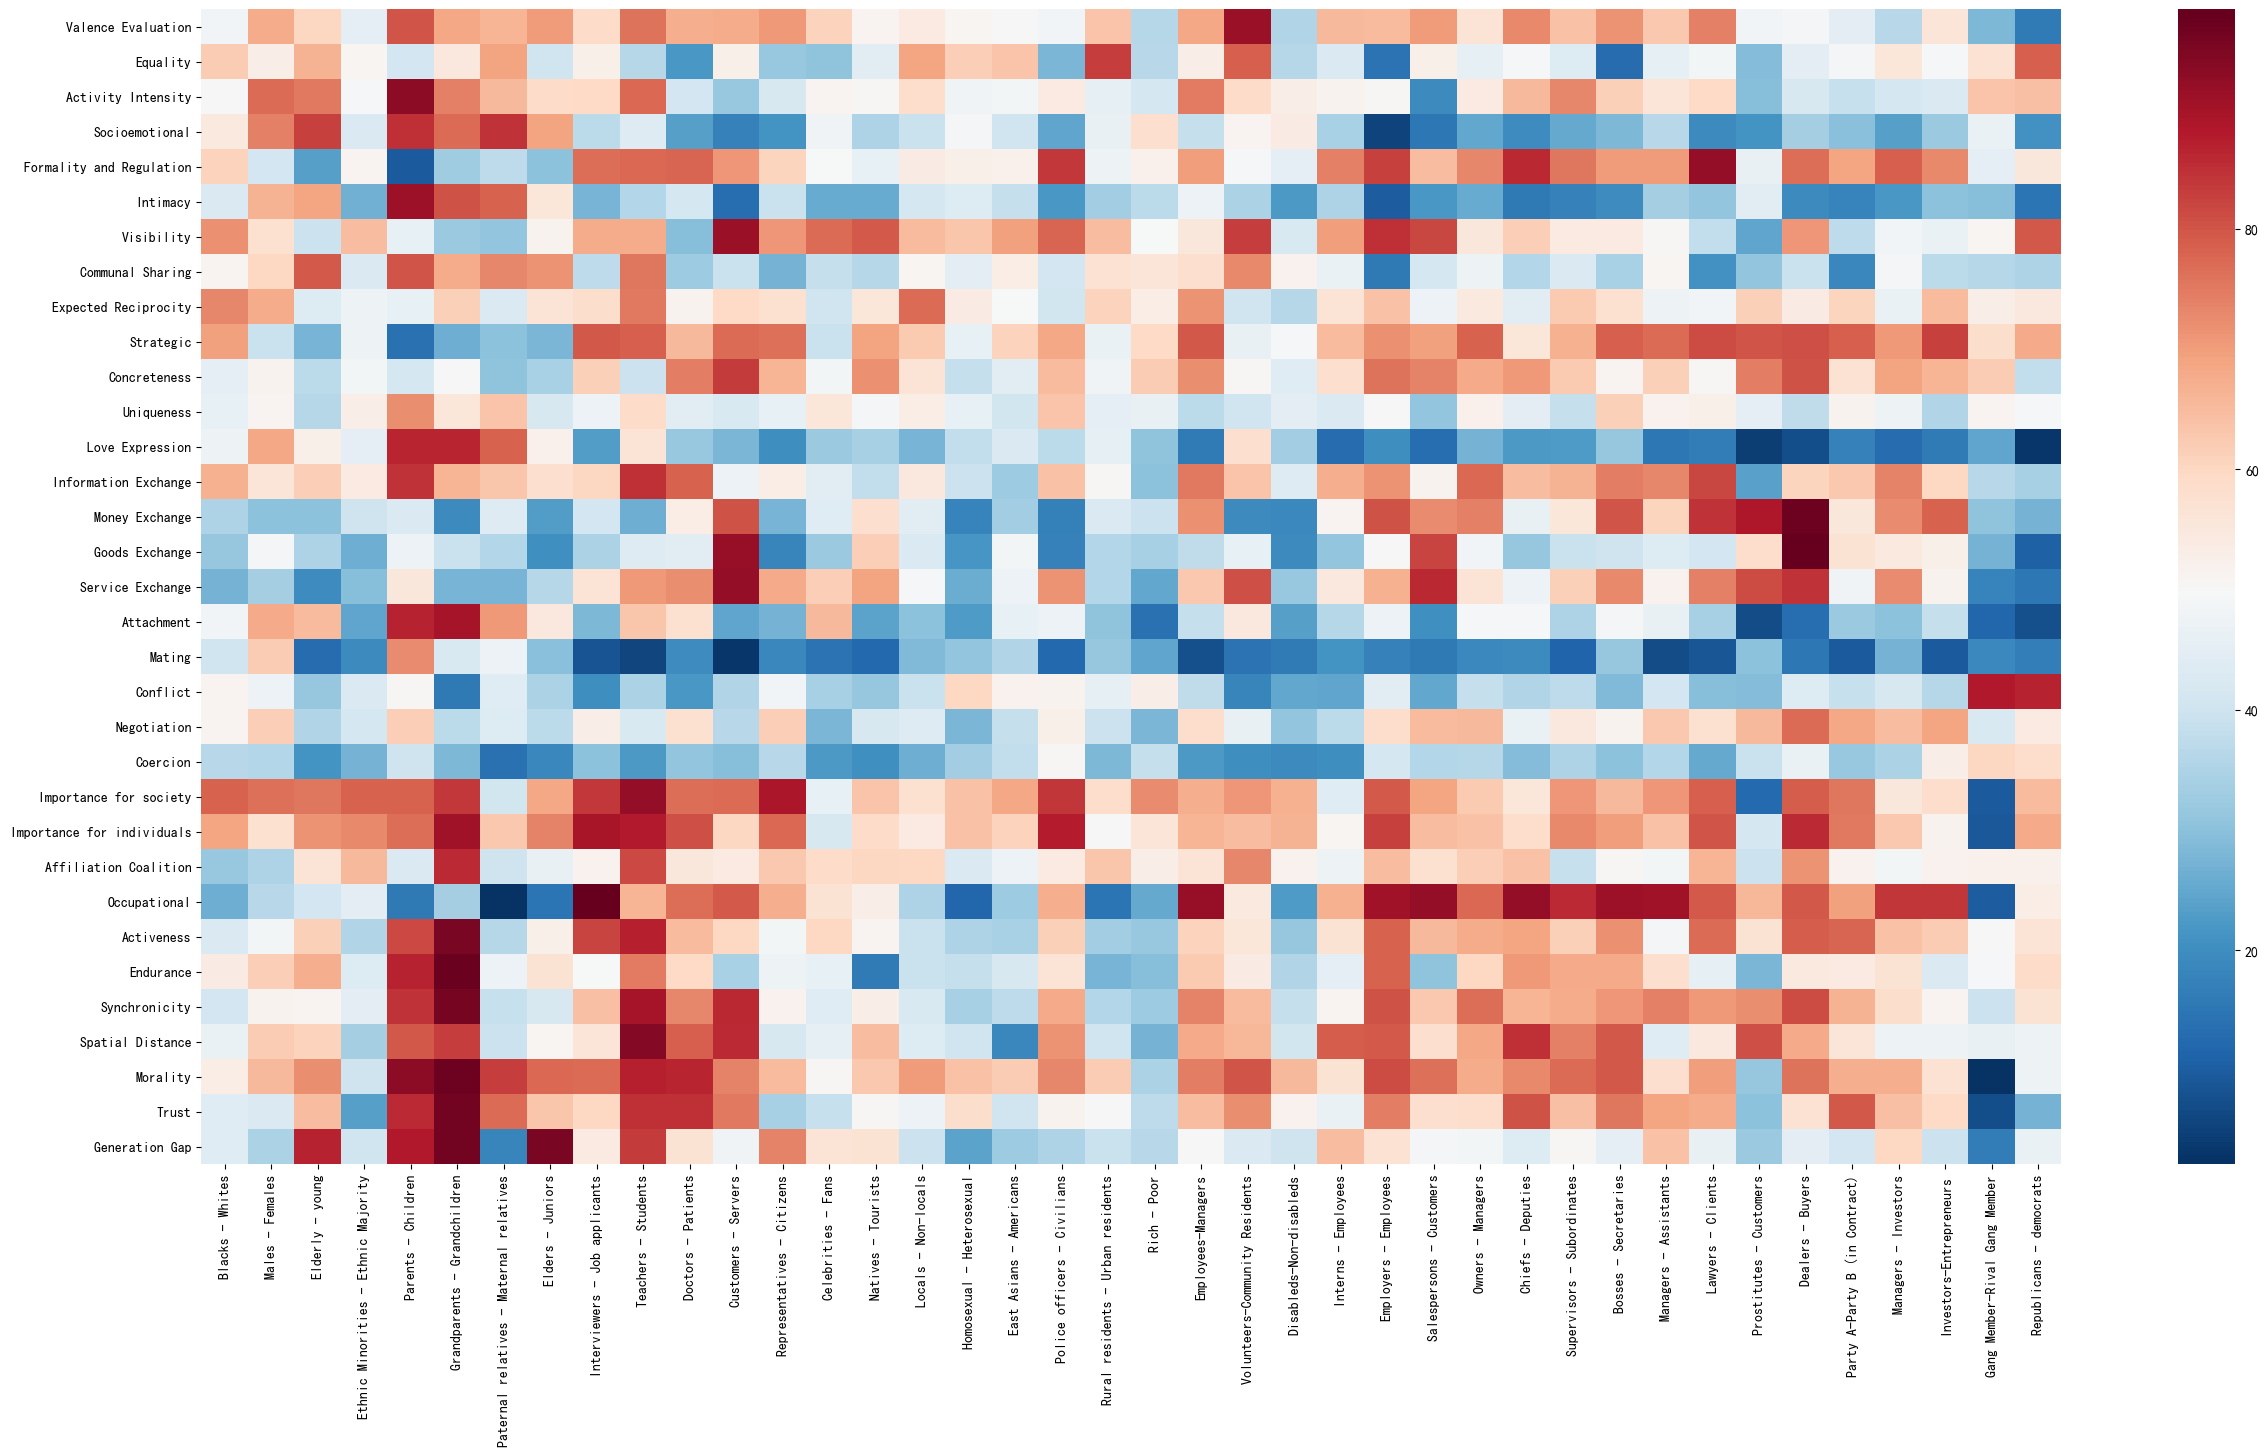

In [24]:
dim_rel = pd.DataFrame(columns = relationships)
count=0
for dim in dimensions:
    dim_rel.loc[count] = dimension_frames_outliers[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimensions
dim_rel.to_csv('output_data/cleaning_results/usa_group_dim_rel_33d.csv')

plt.figure(figsize=(30,15))
sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled = pd.DataFrame(dim_rel_scaled,index=dim_rel.columns,columns=dim_rel.index)
dim_rel_scaled.to_csv('output_data/cleaning_results/usa_group_dim_rel_scaled_33d.csv')

# PCA

In [2]:
library(FactoMineR)
library(factoextra)#fviz_eig
library(psych)

library(ggplot2)
library(corrplot)
library(RColorBrewer)

library(tidyverse)
library(reshape)#melt
library(nFactors)#optimal number of components

## optimal dimensions
plotnScree:https://rdrr.io/cran/nFactors/src/R/plotnScree.R

In [3]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   par(col   = 1, pch = 1)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1.3)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1, adj = c(0,0), col = 2)
   }

In [4]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('output_data/cleaning_results/usa_group_dim_rel_scaled_33d.csv', row.names=1,encoding='UTF-8')

# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, model = "components",aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05 

In [5]:
nS$Analysis$Cumu[1:5]

[1] 0.2800326 0.5331207 0.6103007 0.6780950 0.7235060

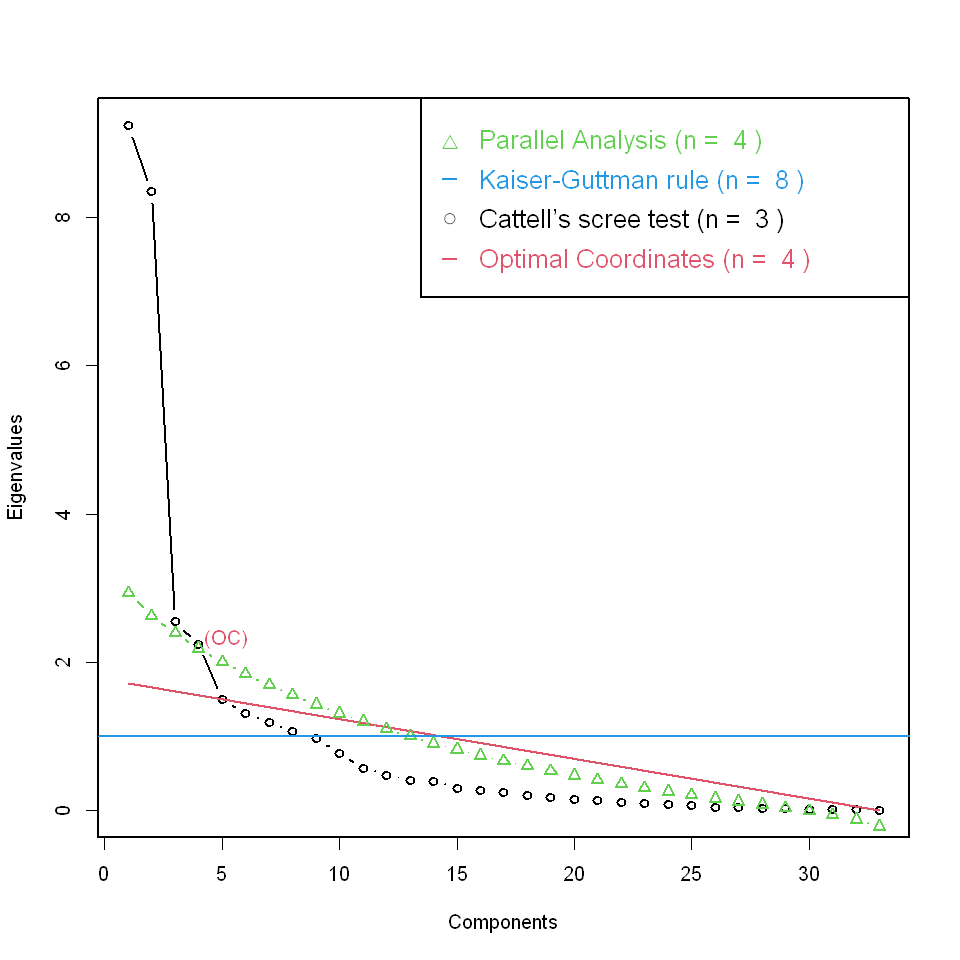

In [6]:
options(repr.plot.width=8,repr.plot.height=8)
plotnScree(nS, elbow = 3,legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

## loading score

In [7]:
dim_rel_scaled = read.csv('output_data/cleaning_results/usa_group_dim_rel_scaled_33d.csv', row.names=1,encoding='UTF-8')

In [8]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat
loadings_var

write.csv(loadings_var,'output_data/pca_results/usa_group_loadings_var_all_5c.csv')
write.csv(scores_var,'output_data/pca_results/usa_group_scores_var_all_5c.csv')


Loadings:
                           [,1]   [,2]   [,3]   [,4]   [,5]  
Valence.Evaluation          0.217 -0.599 -0.465         0.283
Equality                    0.457  0.311  0.126 -0.512       
Activity.Intensity          0.510 -0.492  0.191  0.158 -0.372
Socioemotional              0.927        -0.105        -0.224
Formality.and.Regulation   -0.850 -0.236                0.120
Intimacy                    0.897 -0.176         0.202       
Visibility                 -0.299               -0.643       
Communal.Sharing            0.829 -0.177 -0.178 -0.156       
Expected.Reciprocity              -0.136  0.405 -0.222  0.289
Strategic                  -0.827         0.221         0.319
Concreteness               -0.634                       0.595
Uniqueness                  0.225 -0.315  0.185  0.467 -0.382
Love.Expression             0.851 -0.307 -0.146        -0.205
Information.Exchange              -0.827         0.153       
Money.Exchange             -0.469                0.248  0.7

### original loading

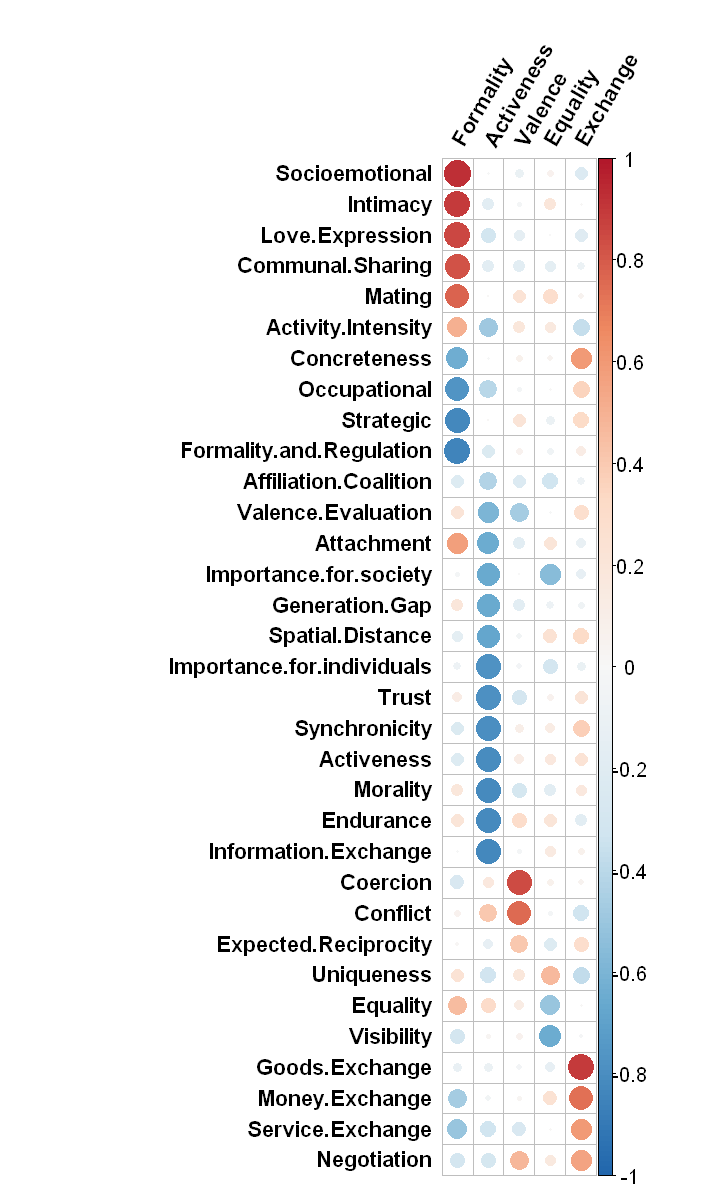

In [9]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','Equality','Exchange')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Formality))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Activeness))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(Valence))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Equality))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Exchange))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1.0,1.0),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

### tailored loading

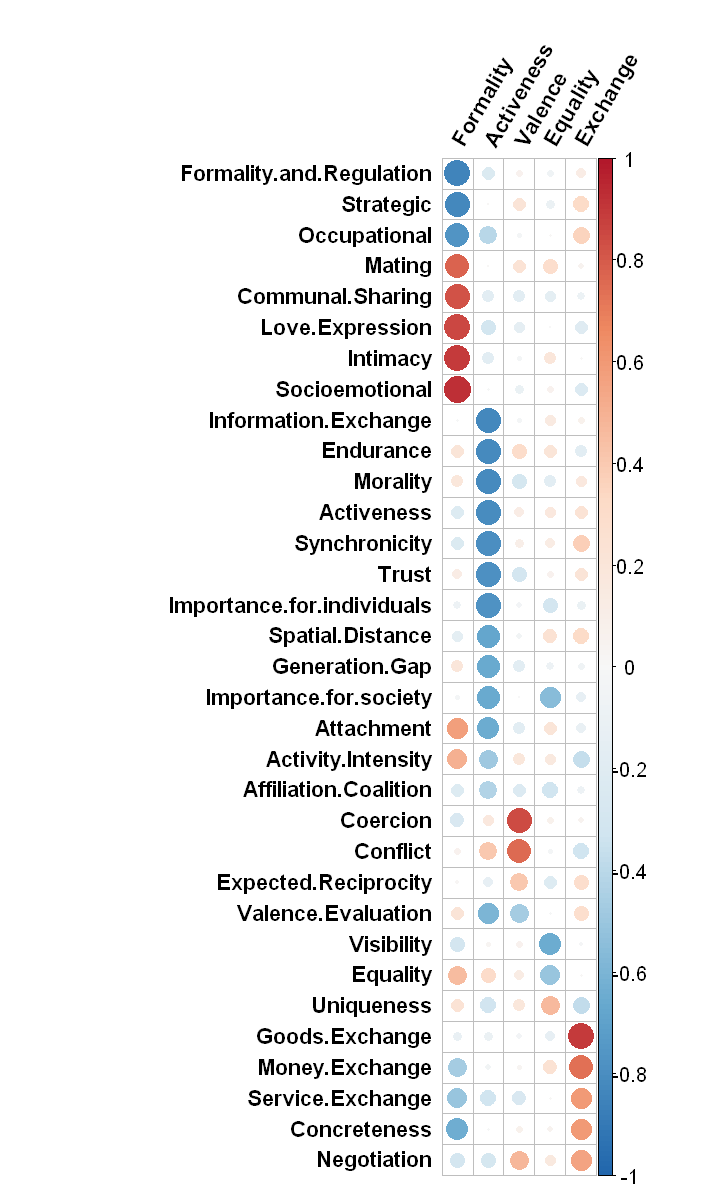

In [10]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','Equality','Exchange')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    # change items in dimention manually!!
    if (rownames(loadings_var_reorder)[row] == 'Activity.Intensity') {
        n = 2
    } 
    else if (rownames(loadings_var_reorder)[row] == 'Valence.Evaluation') {
        n = 3
    } 
     else if (rownames(loadings_var_reorder)[row] == 'Concreteness') {
        n = 5
    } else {    
        for (col in c(2:5)){
            temp = abs(loadings_var_reorder[row,col])
            if (temp > temp_max){
                temp_max = temp
                n = col
            }
        }        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(Formality)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(Activeness)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(Valence))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(Equality)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Exchange))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1.0,1.0),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

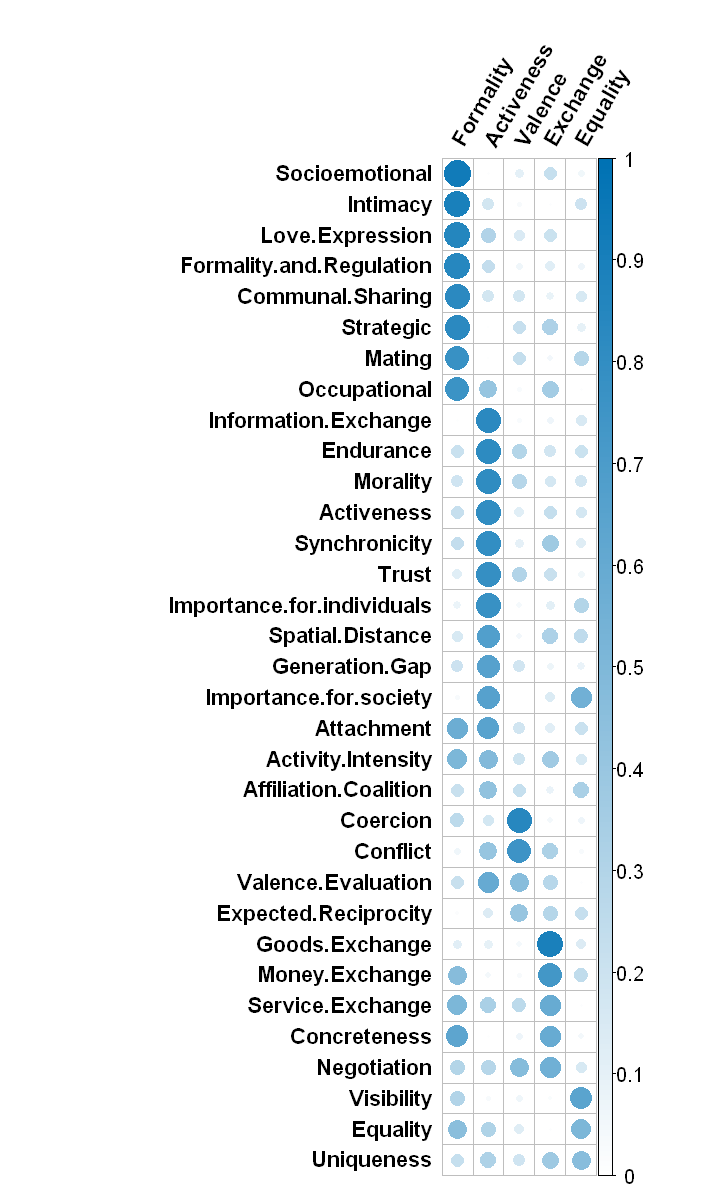

In [11]:
# tailored one color loading

loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','Equality','Exchange')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    # change items in dimention manually!!
    if (rownames(loadings_var_reorder)[row] == 'Activity.Intensity') {
        n = 2
    } 
    else if (rownames(loadings_var_reorder)[row] == 'Valence.Evaluation') {
        n = 3
    } 
     else if (rownames(loadings_var_reorder)[row] == 'Concreteness') {
        n = 5
    } else {    
        for (col in c(2:5)){
            temp = abs(loadings_var_reorder[row,col])
            if (temp > temp_max){
                temp_max = temp
                n = col
            }
        }        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder = loadings_var_reorder %>%
  mutate(
    Exchange = abs(Exchange),
    Activeness = abs(Activeness),
    Equality = abs(Equality),
    Formality = abs(Formality),
    Valence = abs(Valence)
    )
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Formality))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Activeness))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(Valence))
RC4 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Exchange))
RC5 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Equality))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder[,c('Formality','Activeness','Valence','Equality','Exchange')] <- loadings_var_reorder[,c('Formality','Activeness','Valence','Exchange','Equality')]
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','Exchange','Equality')
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(0,1.0),cl.ratio = 0.4,cl.cex=1,
        col = colorRampPalette(c("white",'#0072B4'))(length(my.breaks)))

In [12]:
namepure <- gsub("\\.", " ", rownames(loadings_var_reorder))
names <- paste(namepure, collapse = "\n")
cat(names)

Socioemotional
Intimacy
Love Expression
Formality and Regulation
Communal Sharing
Strategic
Mating
Occupational
Information Exchange
Endurance
Morality
Activeness
Synchronicity
Trust
Importance for individuals
Spatial Distance
Generation Gap
Importance for society
Attachment
Activity Intensity
Affiliation Coalition
Coercion
Conflict
Valence Evaluation
Expected Reciprocity
Goods Exchange
Money Exchange
Service Exchange
Concreteness
Negotiation
Visibility
Equality
Uniqueness

## relationship score

In [14]:
library(ggrepel)
scores_var_plot = data.frame(scores_var)
colnames(scores_var_plot) = c('Formality','Activeness','Valence','Equality','Exchange')
scores_var_plot['Formality'] = -scores_var_plot['Formality']
scores_var_plot['Equality'] = -scores_var_plot['Equality']
scores_var_plot['Activeness'] = -scores_var_plot['Activeness']
scores_var_plot['Exchange'] = scores_var_plot['Exchange']
scores_var_plot['Valence'] = -scores_var_plot['Valence']

scores_var_plot['rel'] = rownames(scores_var_plot)

In [15]:
Plot_scatter = 
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      panel.background = element_rect(fill = 'black'), 
      axis.title=element_text(size=28,face='bold'),
      axis.text=element_text(size=28,face='bold'))

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


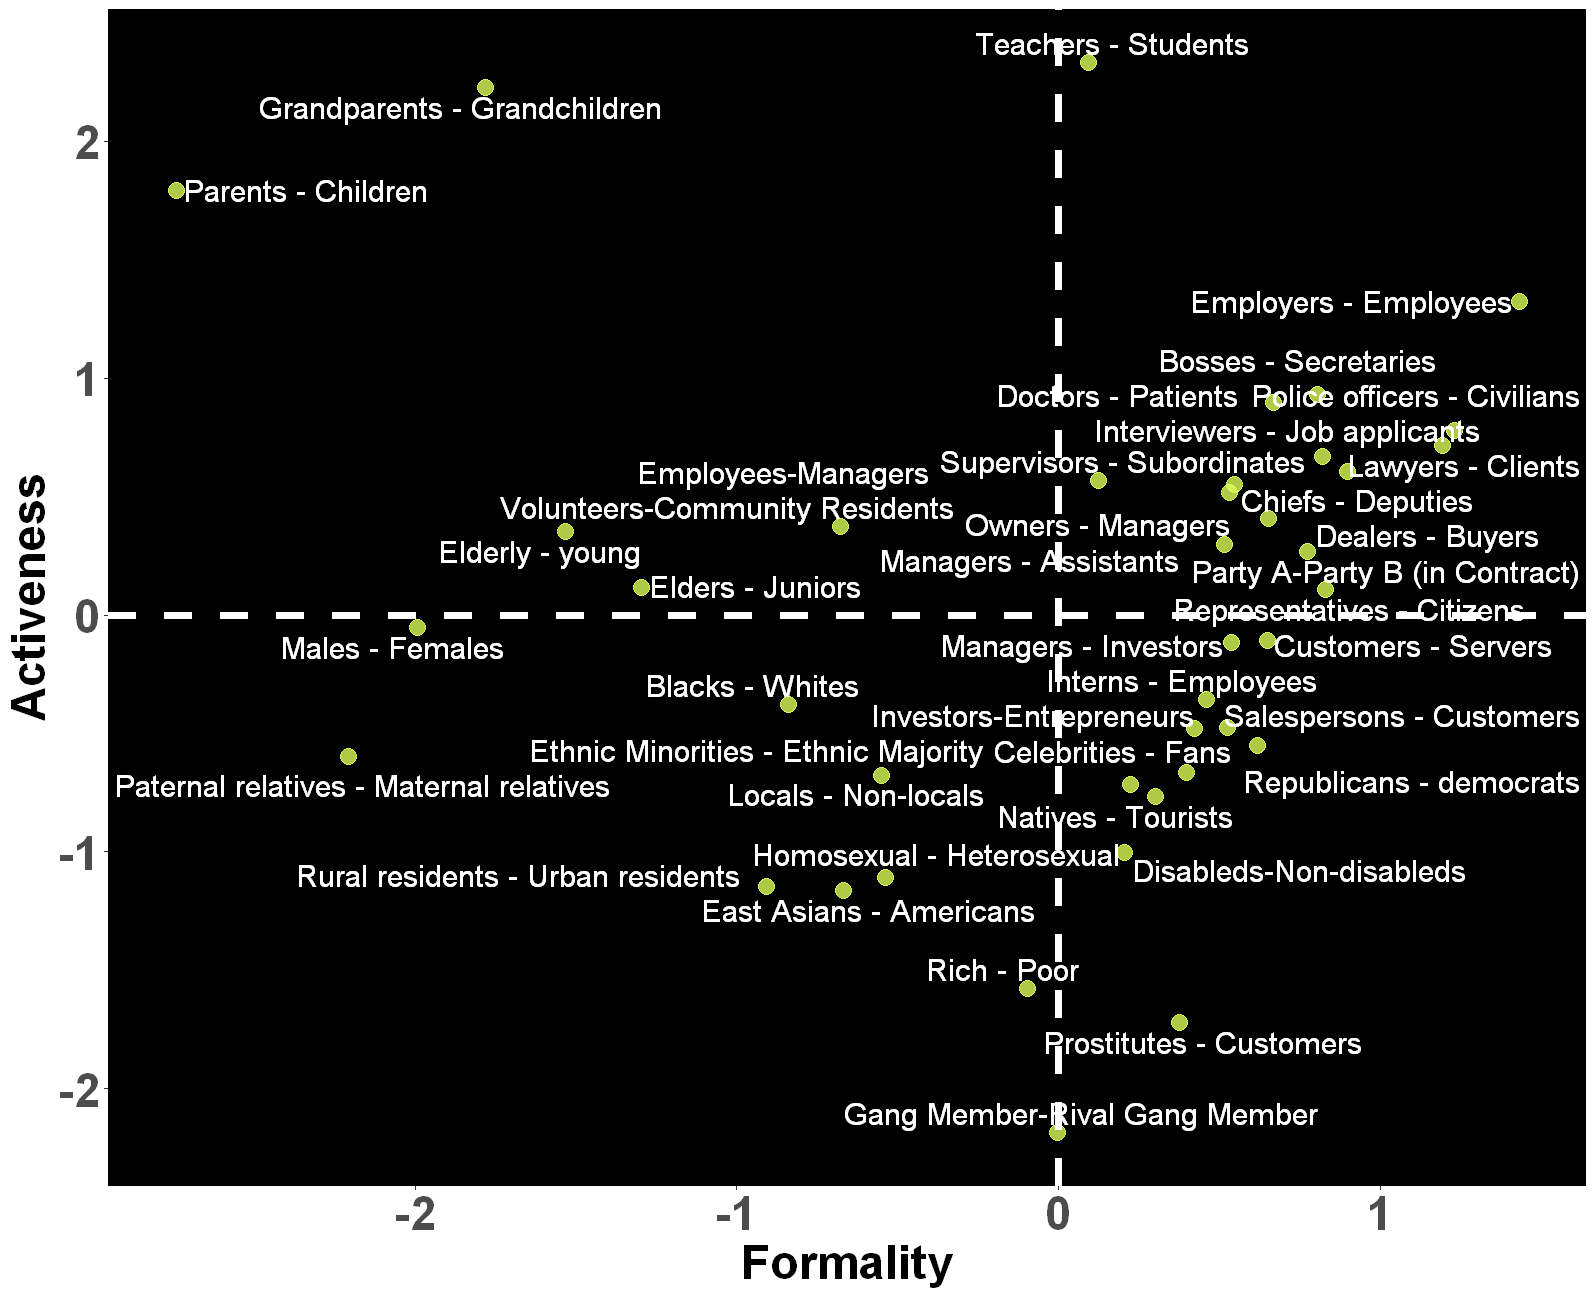

Warning message:
"ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


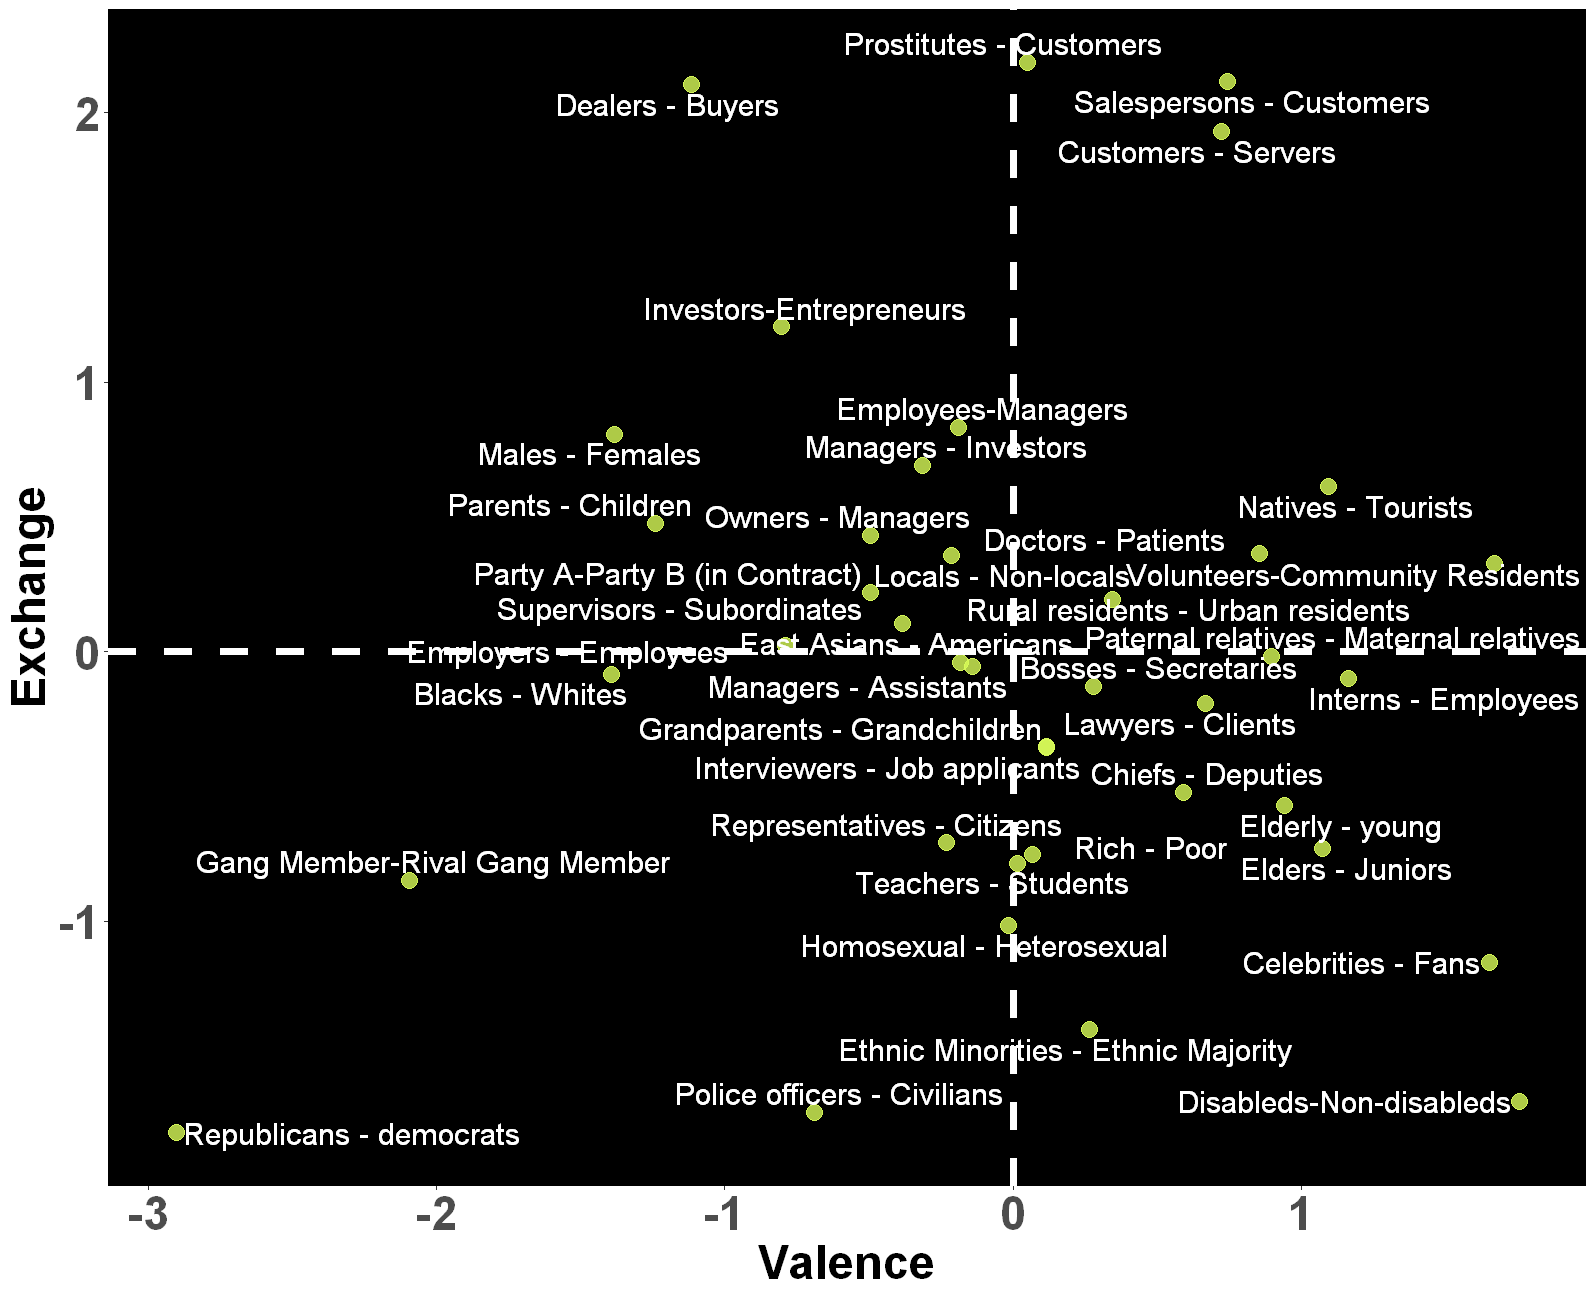

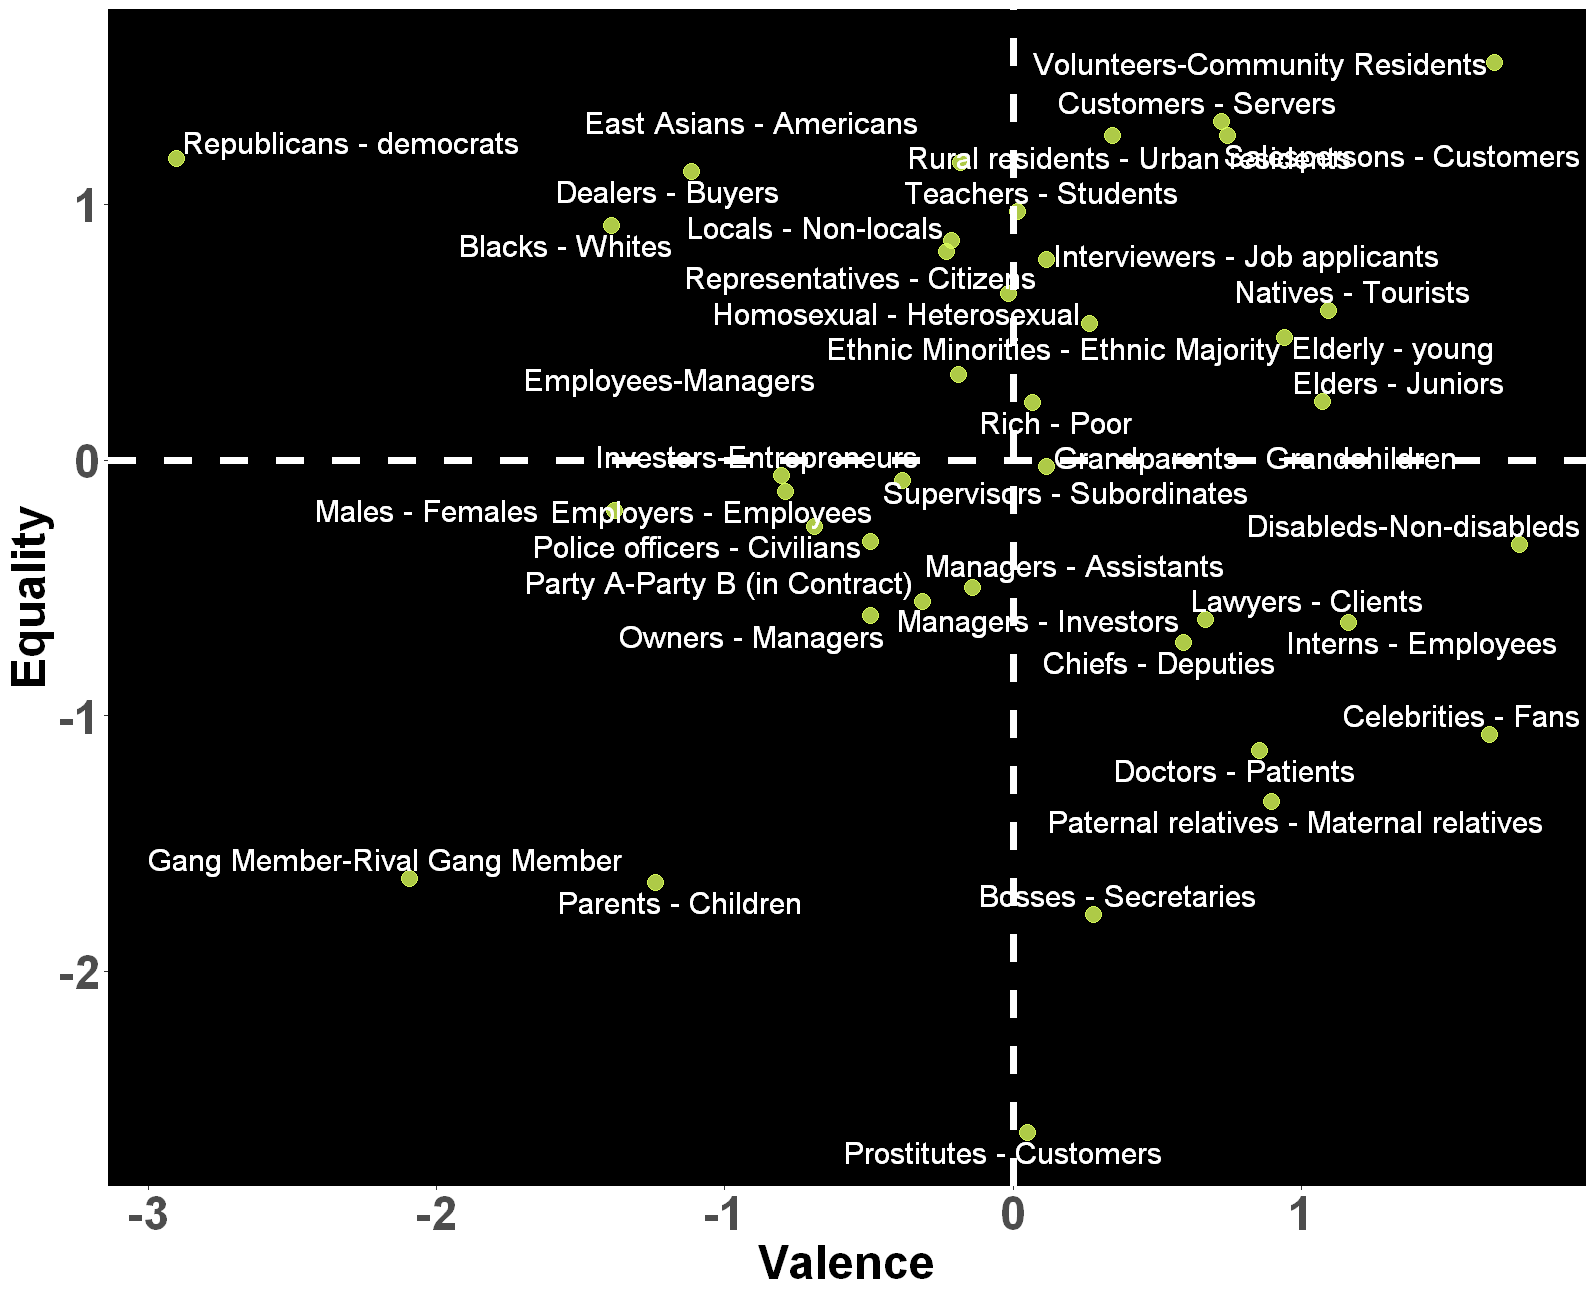

In [16]:
randomseed = 2022
options(repr.plot.height=10.82,repr.plot.width=13.3)
ggplot(scores_var_plot, aes(x=Formality,y=Activeness))+
geom_point(color='#DAFD59',alpha=0.8,size=4.5)+
geom_text_repel(aes(label=rel),size=6.5,
                seed = randomseed,,color='white',
                min.segment.length = Inf)+
geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
Plot_scatter


ggplot(scores_var_plot, aes(x=Valence,y=Exchange))+
geom_point(color='#DAFD59',alpha=0.8,size=4.5)+
geom_text_repel(aes(label=rel),size=6.5,
                seed = randomseed,,color='white',
                min.segment.length = Inf)+
geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
Plot_scatter


ggplot(scores_var_plot, aes(x=Valence,y=Equality))+
geom_point(color='#DAFD59',alpha=0.8,size=4.5)+
geom_text_repel(aes(label=rel),size=6.5,
                seed = randomseed,,color='white',
                min.segment.length = Inf)+
geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
Plot_scatter

## other models

## 2 dimensions

In [17]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 2

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

write.csv(loadings_var,'output_data/pca_results/usa_group_loadings_var_all_2c.csv')
write.csv(scores_var,'output_data/pca_results/usa_group_scores_var_all_2c.csv')

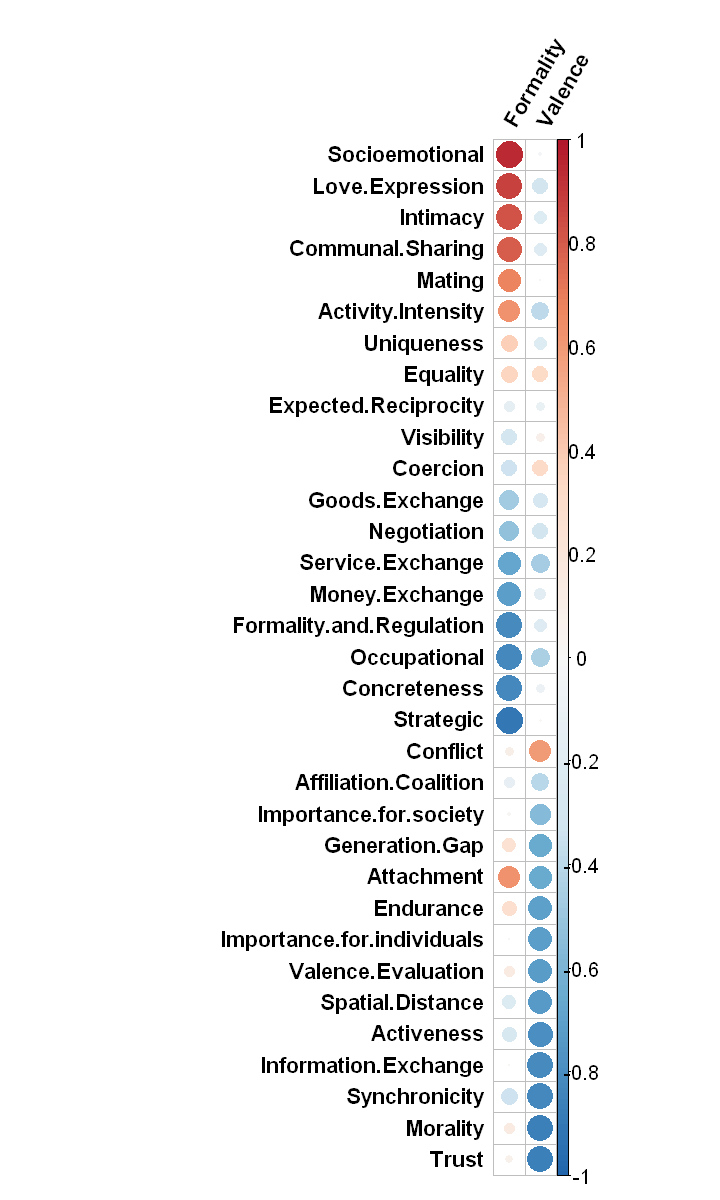

In [18]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))

loadings_var_reorder = rbind(RC1,RC2)
loadings_var_reorder = loadings_var_reorder[1:2]
colnames(loadings_var_reorder) = c('Formality','Valence')

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 1.2,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 3 dimensions

In [19]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 3

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

write.csv(loadings_var,'output_data/pca_results/usa_group_loadings_var_all_3c.csv')
write.csv(scores_var,'output_data/pca_results/usa_group_scores_var_all_3c.csv')

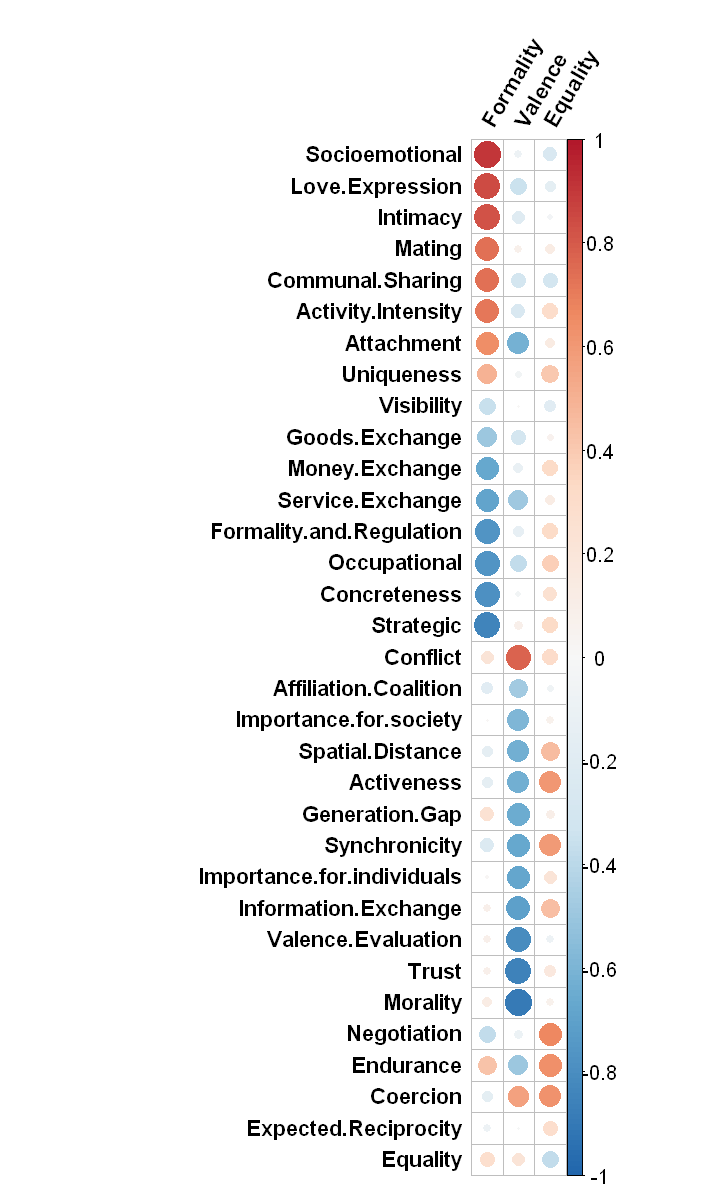

In [20]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:3)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3))

loadings_var_reorder = rbind(RC1,RC2,RC3)
loadings_var_reorder = loadings_var_reorder[1:3]
colnames(loadings_var_reorder) = c('Formality','Valence','Equality')

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.8,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 4 dimensions

In [21]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 4

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

write.csv(loadings_var,'output_data/pca_results/usa_group_loadings_var_all_4c.csv')
write.csv(scores_var,'output_data/pca_results/usa_group_scores_var_all_4c.csv')

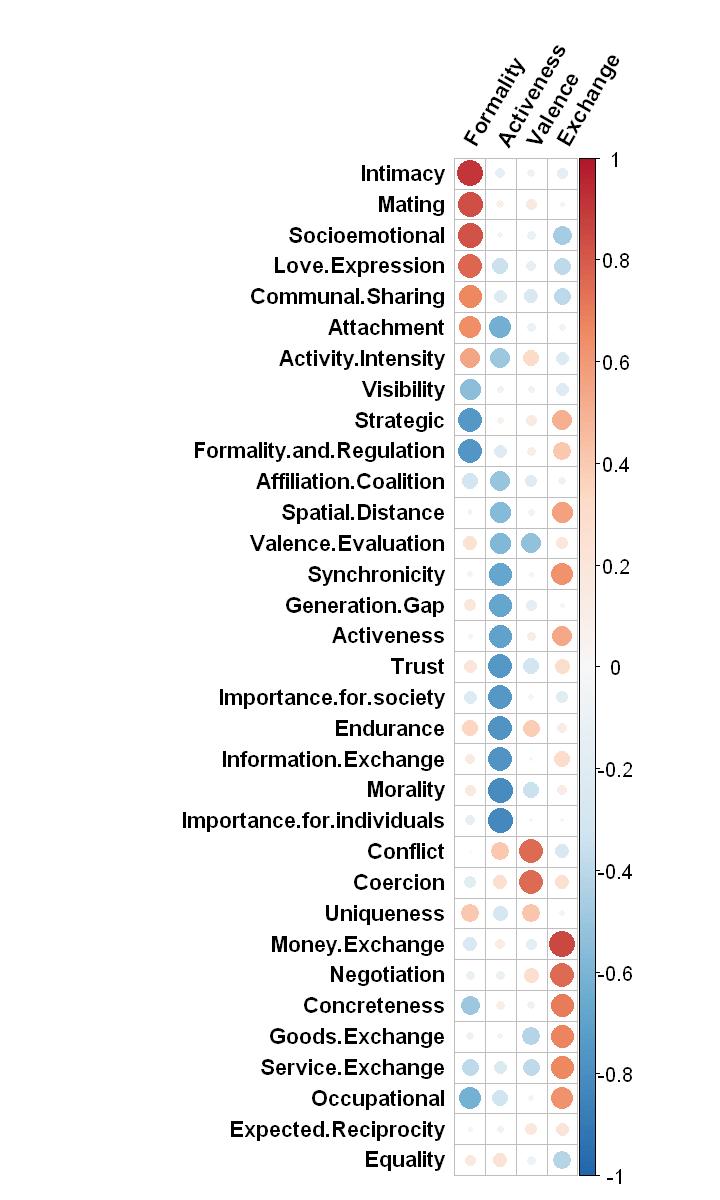

In [22]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:4)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4)
loadings_var_reorder = loadings_var_reorder[1:4]
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','Exchange')

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.6,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 6 dimensions

In [23]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 6

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

write.csv(loadings_var,'output_data/pca_results/usa_group_loadings_var_all_6c.csv')
write.csv(scores_var,'output_data/pca_results/usa_group_scores_var_all_6c.csv')

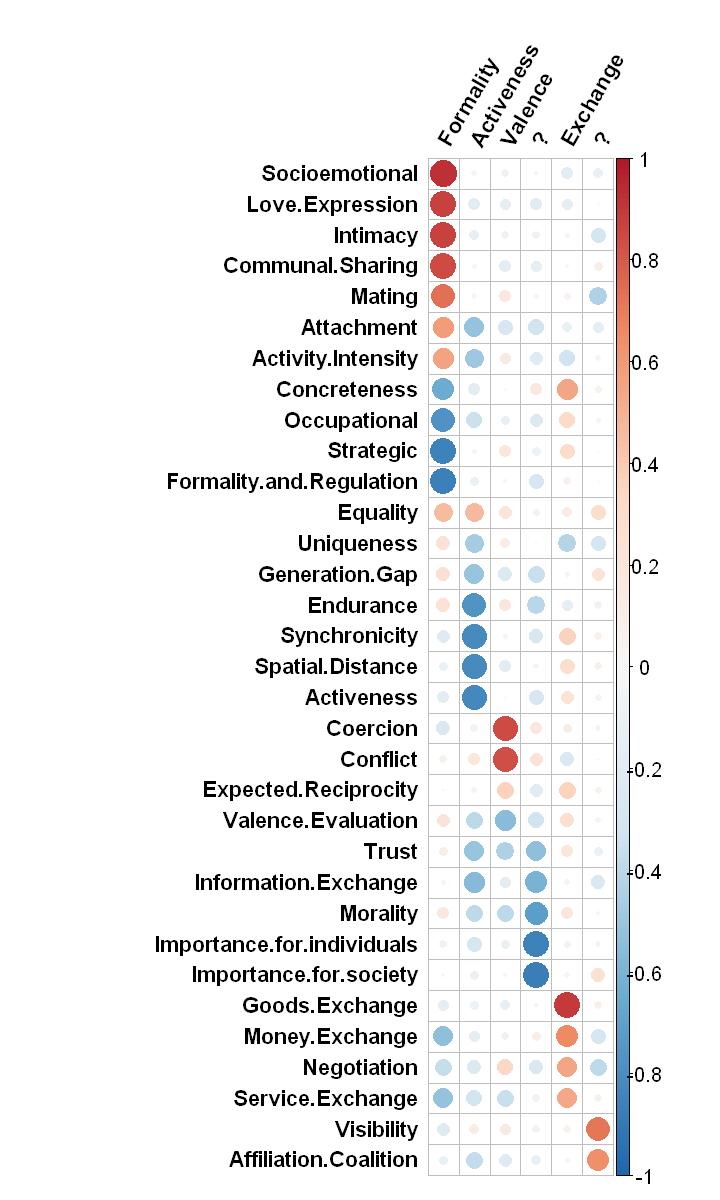

In [24]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:6)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(V5))
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(desc(V6))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6)
loadings_var_reorder = loadings_var_reorder[1:6]
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','?','Exchange','?')

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.3,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))